In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
plt.style.use("ggplot")

In [2]:
import string

In [3]:
df = pd.read_csv("data/result/final/train2.tsv", sep="\t")

In [4]:
df.head(2)

,json_id,label,statement,subject,speaker,job_title,state,party_affiliation,barely_true_counts,false_counts,...,sentiment,question,grammar_errors,ratio_of_capital_letters,curse,emotion,gibberish,offensiveness,political_bias,statement_length
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,...,negative,not_question,1,3.66,NaN,disgust,mild gibberish,non-offensive,CENTER,82
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,...,neutral,question,1,4.26,NaN,neutral,clean,non-offensive,RIGHT,141


# Data preparation

In [5]:
df[["statement", "justification"]] = df[["statement", "justification"]].astype(str)

## Add statement and justification length information

In [6]:
df["statement_len"] = df["statement"].apply(len)
df["justification_len"] = df["justification"].apply(len)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10269 entries, 0 to 10268
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   json_id                   10269 non-null  object 
 1   label                     10269 non-null  object 
 2   statement                 10269 non-null  object 
 3   subject                   10269 non-null  object 
 4   speaker                   10269 non-null  object 
 5   job_title                 7367 non-null   object 
 6   state                     8058 non-null   object 
 7   party_affiliation         10269 non-null  object 
 8   barely_true_counts        10269 non-null  float64
 9   false_counts              10269 non-null  float64
 10  half_true_counts          10269 non-null  float64
 11  mostly_true_counts        10269 non-null  float64
 12  pants_on_fire_counts      10269 non-null  float64
 13  context                   10169 non-null  object 
 14  justif

In [8]:
df = df.drop(["json_id"], axis=1)

In [9]:
pd.set_option('display.max_columns', 200)
df.head(2)

,label,statement,subject,speaker,job_title,state,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context,justification,sentiment,question,grammar_errors,ratio_of_capital_letters,curse,emotion,gibberish,offensiveness,political_bias,statement_length,statement_len,justification_len
0,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,That's a premise that he fails to back up. Ann...,negative,not_question,1,3.66,NaN,disgust,mild gibberish,non-offensive,CENTER,82,82,248
1,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,"Surovell said the decline of coal ""started whe...",neutral,question,1,4.26,NaN,neutral,clean,non-offensive,RIGHT,141,141,637


## Add two-way label

In [10]:
df["bin_label"] = df["label"].apply(lambda x: "true" if x in ["half-true", "mostly-true", "true"] else "false")

## Label as a score

In [11]:
score = {
    "pants-fire": -3,
    "false": -2,
    "barely-true": -1,
    "half-true": 1,
    "mostly-true": 2,
    "true": 3
}
df["label_score"] = df["label"].apply(lambda x: score[x])

In [12]:
df.describe()

,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,grammar_errors,ratio_of_capital_letters,statement_length,statement_len,justification_len,label_score
count,10269.000000,10269.000000,10269.000000,10269.000000,10269.000000,10269.000000,10269.000000,10269.000000,10269.000000,10269.000000,10269.000000
mean,11.560132,13.313857,17.195637,16.490505,6.202746,0.382705,3.684727,106.201188,106.201188,425.242964,0.284838
std,19.006447,24.140583,35.948211,36.251253,16.117701,0.674683,2.580085,45.079303,45.079303,314.071139,2.011068
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,11.000000,3.000000,-3.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.900000,73.000000,73.000000,270.000000,-2.000000
50%,2.000000,2.000000,3.000000,3.000000,1.000000,0.000000,3.170000,99.000000,99.000000,394.000000,1.000000
75%,12.000000,15.000000,13.000000,11.000000,5.000000,1.000000,4.790000,132.000000,132.000000,534.000000,2.000000
max,70.000000,114.000000,160.000000,163.000000,105.000000,7.000000,81.670000,395.000000,395.000000,9394.000000,3.000000


In [13]:
# Delete row with 13 grammar errors because it wos corrupted
df = df[df["grammar_errors"] != 13]

In [14]:
# Change values in curse column and fill null values
df["curse"] = df["curse"].fillna("No")
df["curse"] = df["curse"].replace("Curse", "Yes")

## Feature understanding

<Axes: title={'center': 'Number of statements classified as curse'}, xlabel='curse'>

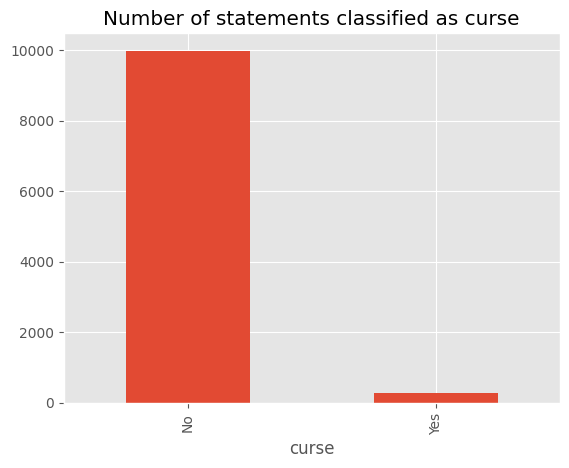

In [15]:
df["curse"].value_counts().plot(kind="bar", title="Number of statements classified as curse")

<Axes: title={'center': 'Distribution of capital letters ratio'}, xlabel='ratio_of_capital_letters'>

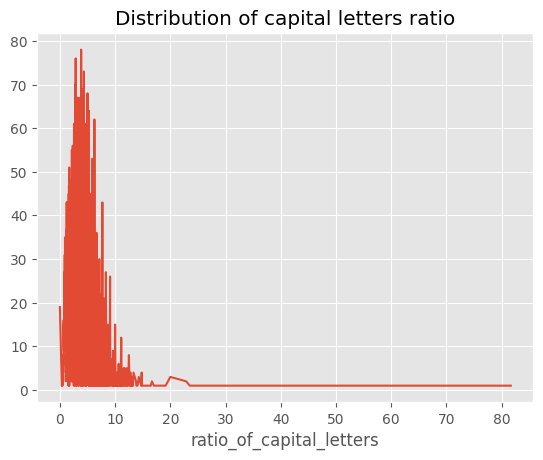

In [16]:
df["ratio_of_capital_letters"].value_counts() \
    .sort_index(ascending=True) \
    .plot(title="Distribution of capital letters ratio")

<Axes: title={'center': 'Distibution of Emotions'}, xlabel='emotion'>

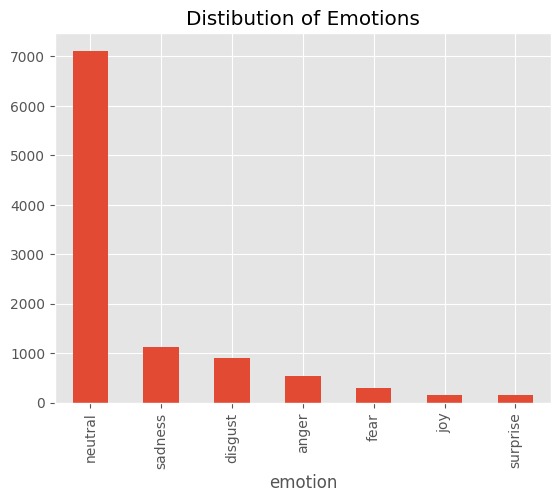

In [17]:
df["emotion"].value_counts().plot(kind="bar", title="Distibution of Emotions")

<Axes: title={'center': 'Number of gibberish values'}, xlabel='gibberish'>

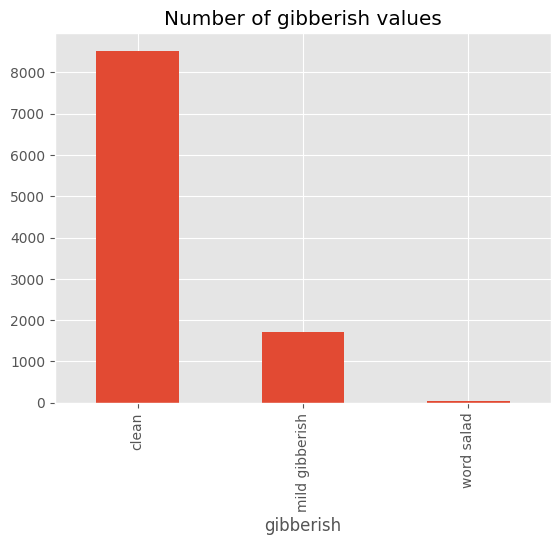

In [18]:
df["gibberish"].value_counts().plot(kind="bar", title="Number of gibberish values")

<Axes: title={'center': 'Number of offensive statements'}, xlabel='offensiveness'>

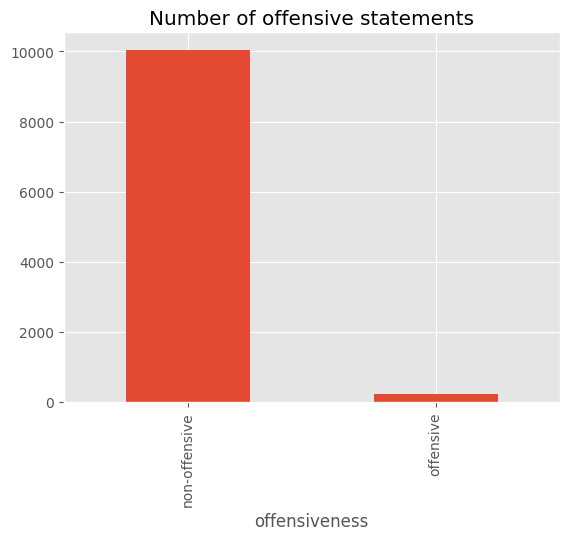

In [19]:
df["offensiveness"].value_counts().plot(kind="bar", title="Number of offensive statements")

<Axes: title={'center': 'Political bias distribution'}, xlabel='political_bias'>

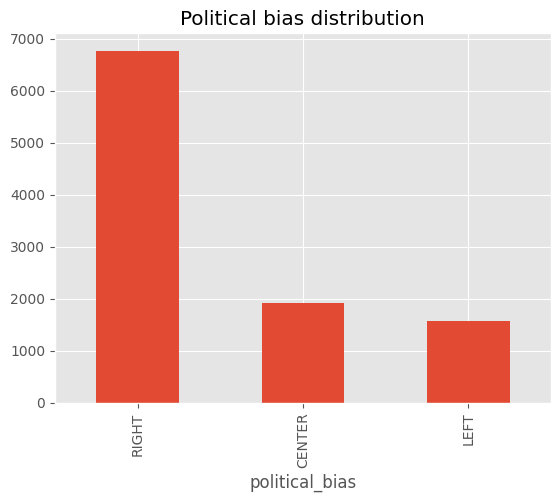

In [20]:
df["political_bias"].value_counts().plot(kind="bar", title="Political bias distribution")

<Axes: title={'center': 'Statement length'}, xlabel='statement_len'>

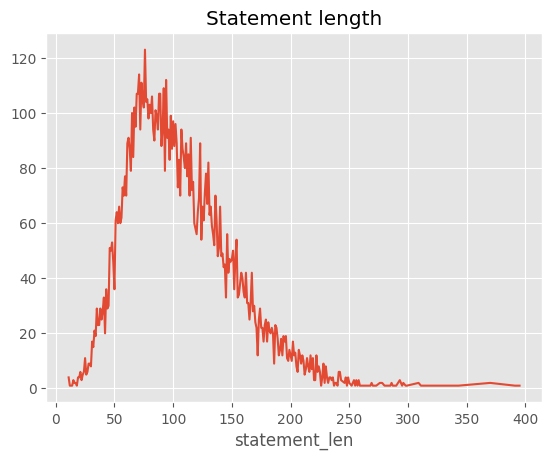

In [21]:
df["statement_len"].value_counts() \
.sort_index(ascending=True) \
.plot(title="Statement length")

<Axes: title={'center': 'Party affiliation'}, xlabel='party_affiliation'>

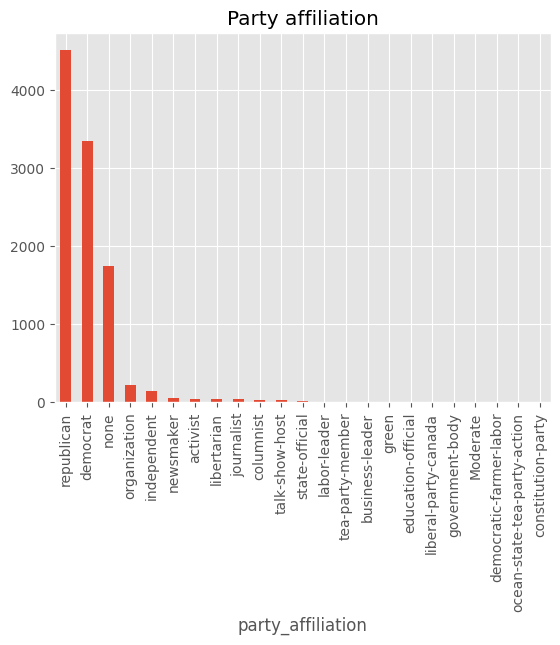

In [22]:
df["party_affiliation"].value_counts() \
.plot(kind="bar", title="Party affiliation")

## Feature relationship

In [23]:
pd.set_option('display.max_colwidth', 30)

df.head(2)

,label,statement,subject,speaker,job_title,state,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context,justification,sentiment,question,grammar_errors,ratio_of_capital_letters,curse,emotion,gibberish,offensiveness,political_bias,statement_length,statement_len,justification_len,bin_label,label_score
0,false,Says the Annies List polit...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,That's a premise that he f...,negative,not_question,1,3.66,No,disgust,mild gibberish,non-offensive,CENTER,82,82,248,false,-2
1,half-true,When did the decline of co...,"energy,history,job-accompl...",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,Surovell said the decline ...,neutral,question,1,4.26,No,neutral,clean,non-offensive,RIGHT,141,141,637,true,1


In [24]:
df[["label_score", "ratio_of_capital_letters", "statement_len"]].corr()

,label_score,ratio_of_capital_letters,statement_len
label_score,1.000000,-0.111349,0.044212
ratio_of_capital_letters,-0.111349,1.000000,-0.262235
statement_len,0.044212,-0.262235,1.000000


# From the above data we can conclude that "statement_length" and "ratio_of_capital_letters" do not give much information about the label. A correlation of -0.26 is insufficient.

   curse  label_score  count  num_of_labels  utility_rate
6    Yes           -3     29            842      3.444181
7    Yes           -2     55           1998      2.752753
8    Yes           -1     49           1657      2.957151
9    Yes            1     53           2123      2.496467
10   Yes            2     48           1966      2.441506
11   Yes            3     49           1683      2.911468


<Axes: title={'center': "Number of labels when curse is 'Yes'"}, xlabel='label_score'>

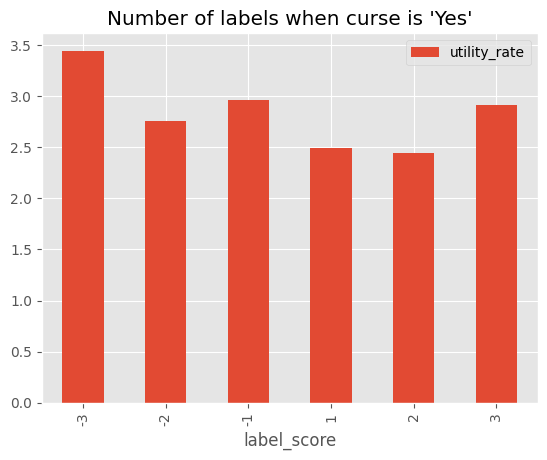

In [25]:
curse_vs_label = df.groupby(['curse', 'label_score']).size().reset_index(name='count')
curse_vs_label = curse_vs_label[curse_vs_label["curse"] == "Yes"]
curse_vs_label["num_of_labels"] = df.groupby('label_score').size().values
curse_vs_label["utility_rate"] = curse_vs_label["count"] / curse_vs_label["num_of_labels"] * 100

print(curse_vs_label)

curse_vs_label[curse_vs_label["curse"] == "Yes"] \
.plot(kind="bar", x='label_score', y='utility_rate', title="Number of labels when curse is 'Yes'")

  curse bin_label  count  num_of_labels  utility_rate
2   Yes     false    133           4497      2.957527
3   Yes      true    150           5772      2.598753


<Axes: title={'center': "Number of binary labels when curse is 'Yes'"}, xlabel='bin_label'>

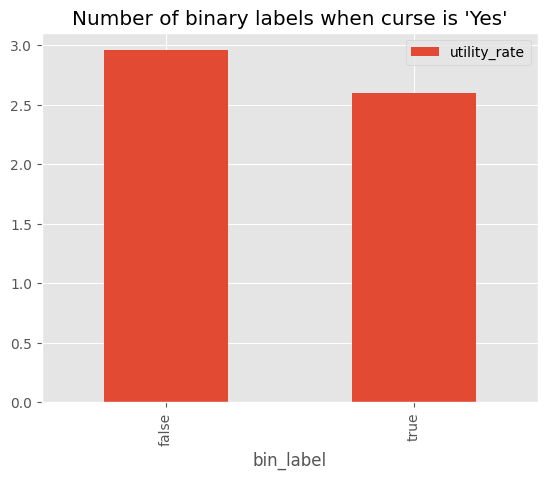

In [26]:
curse_vs_label = df.groupby(['curse', 'bin_label']).size().reset_index(name='count')
curse_vs_label = curse_vs_label[curse_vs_label["curse"] == "Yes"]
curse_vs_label["num_of_labels"] = df.groupby('bin_label').size().values
curse_vs_label["utility_rate"] = curse_vs_label["count"] / curse_vs_label["num_of_labels"] * 100

print(curse_vs_label)

curse_vs_label[curse_vs_label["curse"] == "Yes"] \
.plot(kind="bar", x='bin_label', y='utility_rate', title="Number of binary labels when curse is 'Yes'")

# From the above data, we can conclude that the column "curse" is quite useful for predicting the label of the statement. The importance of this column increases in binary classification.

     emotion  label_score  count  num_of_labels  utility_rate
0      anger           -3     45            842      5.344418
1      anger           -2    124           1998      6.206206
2      anger           -1    111           1657      6.698853
3      anger            1    110           2123      5.181347
4      anger            2     66           1966      3.357070
5      anger            3     75           1683      4.456328
6    disgust           -3    114            842     13.539192
7    disgust           -2    177           1998      8.858859
8    disgust           -1    155           1657      9.354255
9    disgust            1    172           2123      8.101743
10   disgust            2    148           1966      7.527976
11   disgust            3    136           1683      8.080808
12      fear           -3     35            842      4.156770
13      fear           -2     68           1998      3.403403
14      fear           -1     52           1657      3.138202
15      

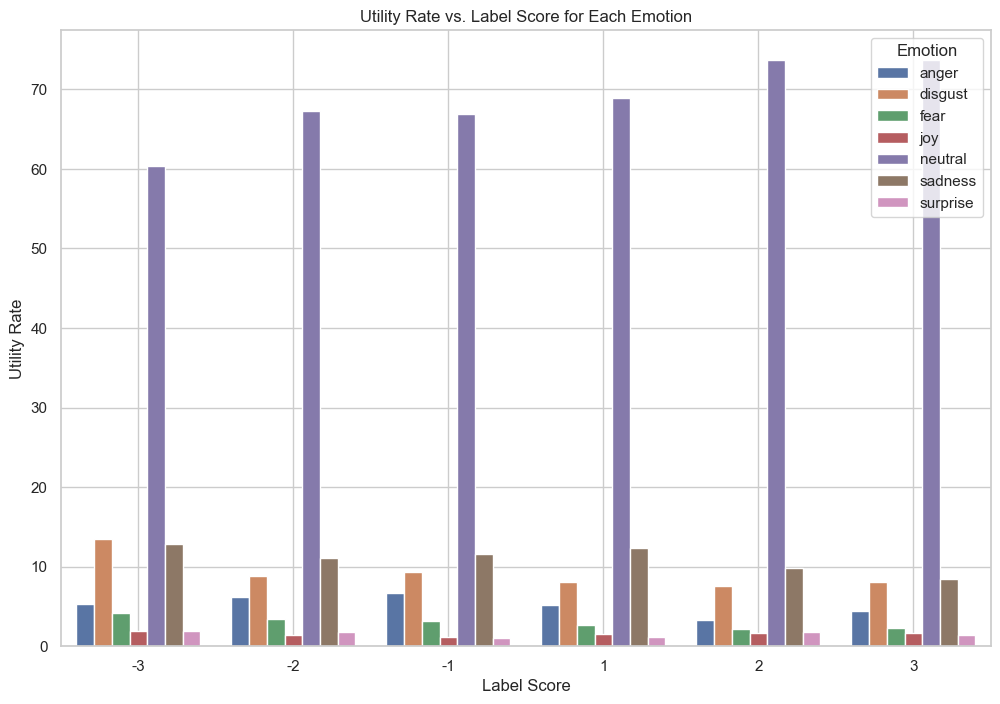

In [27]:
emotion_df = df.groupby(['emotion', 'label_score']).size().reset_index(name='count')
num_of_labels = df.groupby('label_score').size()

emotion_df["num_of_labels"] = emotion_df["label_score"].map(num_of_labels)
emotion_df["utility_rate"] = emotion_df["count"] / emotion_df["num_of_labels"] * 100
print(emotion_df)

plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
sns.barplot(x="label_score", y="utility_rate", hue="emotion", data=emotion_df)

plt.title('Utility Rate vs. Label Score for Each Emotion')
plt.xlabel('Label Score')
plt.ylabel('Utility Rate')
plt.grid(True)
plt.legend(title='Emotion')

     emotion bin_label  count  num_of_labels  utility_rate
0      anger     false    280           4497      6.226373
1      anger      true    251           5772      4.348579
2    disgust     false    446           4497      9.917723
3    disgust      true    456           5772      7.900208
4       fear     false    155           4497      3.446742
5       fear      true    139           5772      2.408177
6        joy     false     63           4497      1.400934
7        joy      true     92           5772      1.593902
8    neutral     false   2961           4497     65.843896
9    neutral      true   4154           5772     71.968122
10   sadness     false    522           4497     11.607738
11   sadness      true    596           5772     10.325710
12  surprise     false     70           4497      1.556593
13  surprise      true     84           5772      1.455301


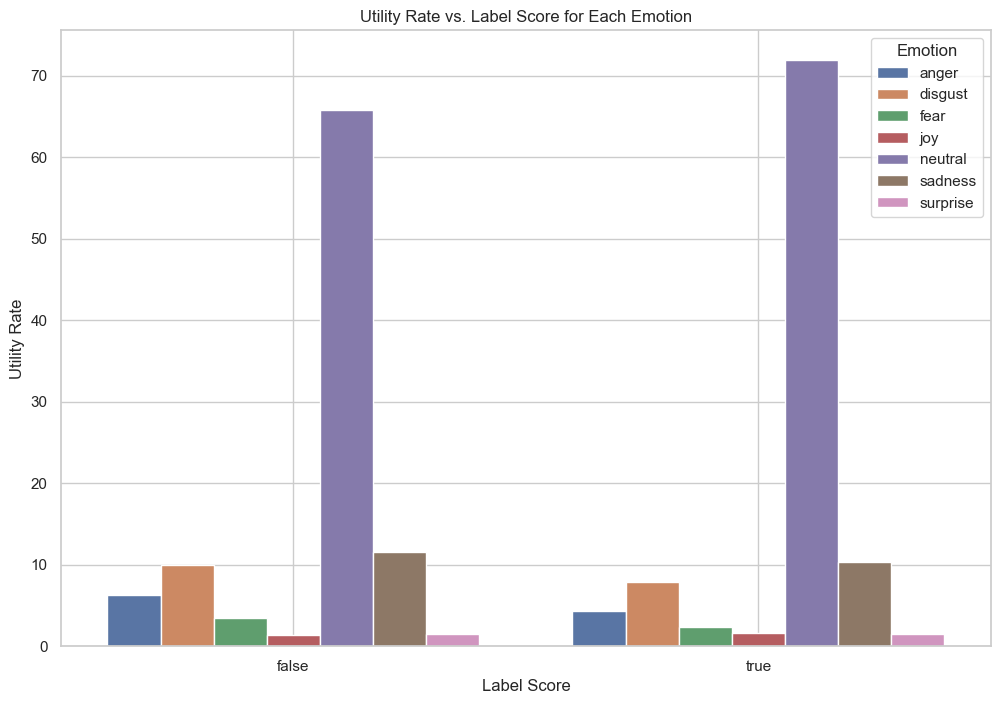

In [28]:
emotion_df = df.groupby(['emotion', 'bin_label']).size().reset_index(name='count')
num_of_labels = df.groupby('bin_label').size()

emotion_df["num_of_labels"] = emotion_df["bin_label"].map(num_of_labels)
emotion_df["utility_rate"] = emotion_df["count"] / emotion_df["num_of_labels"] * 100
print(emotion_df)

plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
sns.barplot(x="bin_label", y="utility_rate", hue="emotion", data=emotion_df)

plt.title('Utility Rate vs. Label Score for Each Emotion')
plt.xlabel('Label Score')
plt.ylabel('Utility Rate')
plt.grid(True)
plt.legend(title='Emotion')

# From the above data, we can conclude that the column "emotion" is useful for predicting the label of the statement. True statements are more neutral.

         gibberish  label_score  count  num_of_labels  utility_rate
0            clean           -3    686            842     81.472684
1            clean           -2   1637           1998     81.931932
2            clean           -1   1364           1657     82.317441
3            clean            1   1764           2123     83.089967
4            clean            2   1658           1966     84.333672
5            clean            3   1416           1683     84.135472
6   mild gibberish           -3    156            842     18.527316
7   mild gibberish           -2    345           1998     17.267267
8   mild gibberish           -1    291           1657     17.561859
9   mild gibberish            1    348           2123     16.391898
10  mild gibberish            2    306           1966     15.564598
11  mild gibberish            3    262           1683     15.567439
12      word salad           -2     16           1998      0.800801
13      word salad           -1      2          

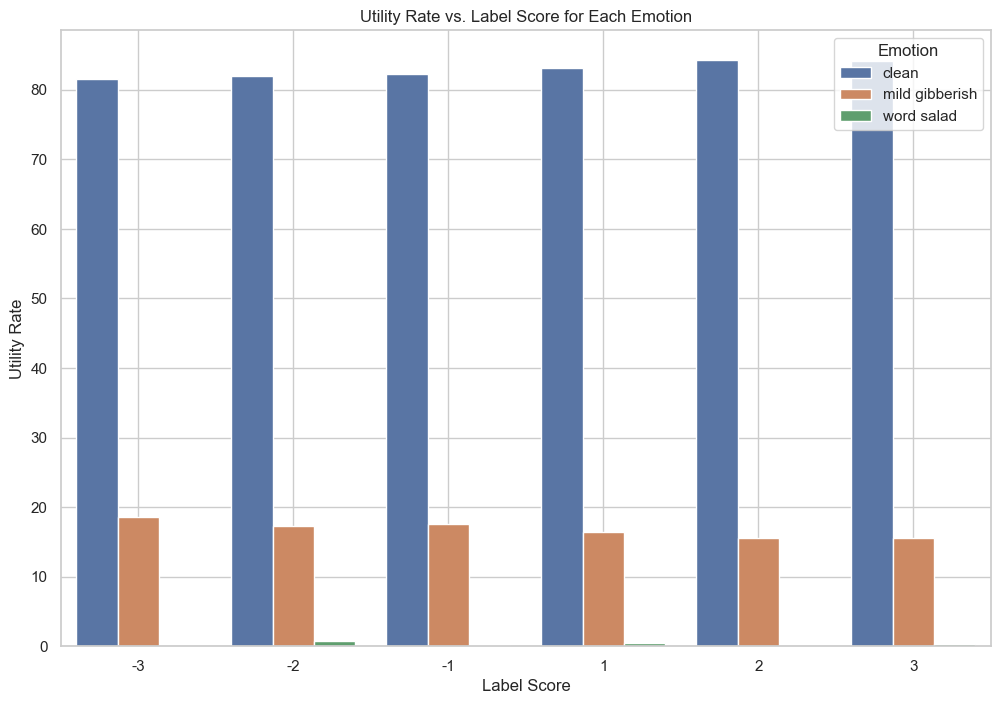

In [29]:
gibberish_df = df.groupby(['gibberish', 'label_score']).size().reset_index(name='count')
num_of_labels = df.groupby('label_score').size()
gibberish_df["num_of_labels"] = gibberish_df["label_score"].map(num_of_labels)
gibberish_df["utility_rate"] = gibberish_df["count"] / gibberish_df["num_of_labels"] * 100

print(gibberish_df)

plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
sns.barplot(x="label_score", y="utility_rate", hue="gibberish", data=gibberish_df)

plt.title('Utility Rate vs. Label Score for Each Emotion')
plt.xlabel('Label Score')
plt.ylabel('Utility Rate')
plt.grid(True)
plt.legend(title='Emotion')

        gibberish bin_label  count  num_of_labels  utility_rate
0           clean     false   3687           4497     81.987992
1           clean      true   4838           5772     83.818434
2  mild gibberish     false    792           4497     17.611741
3  mild gibberish      true    916           5772     15.869716
4      word salad     false     18           4497      0.400267
5      word salad      true     18           5772      0.311850


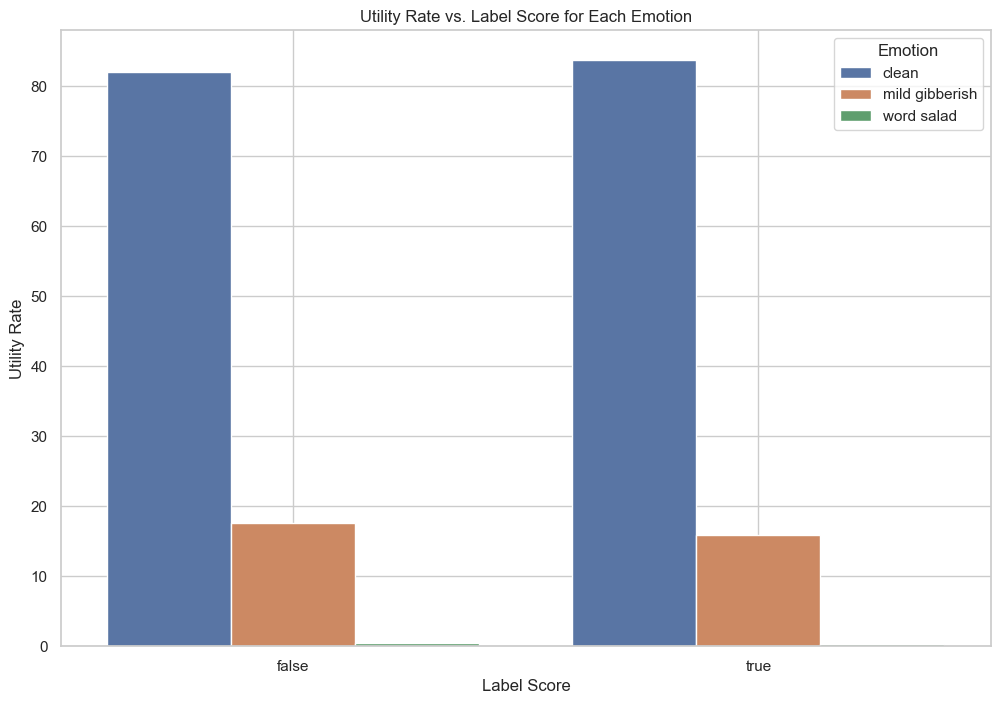

In [30]:
gibberish_df = df.groupby(['gibberish', 'bin_label']).size().reset_index(name='count')
num_of_labels = df.groupby('bin_label').size()
gibberish_df["num_of_labels"] = gibberish_df["bin_label"].map(num_of_labels)
gibberish_df["utility_rate"] = gibberish_df["count"] / gibberish_df["num_of_labels"] * 100

print(gibberish_df)

plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
sns.barplot(x="bin_label", y="utility_rate", hue="gibberish", data=gibberish_df)

plt.title('Utility Rate vs. Label Score for Each Emotion')
plt.xlabel('Label Score')
plt.ylabel('Utility Rate')
plt.grid(True)
plt.legend(title='Emotion')

# From the above data, we can conclude that the column "gibberish" is quite useful for predicting the label of the statement. True statements are less gibberish.

   offensiveness  label_score  count  num_of_labels  utility_rate
6      offensive           -3     45            842      5.344418
7      offensive           -2     43           1998      2.152152
8      offensive           -1     42           1657      2.534701
9      offensive            1     47           2123      2.213848
10     offensive            2     28           1966      1.424212
11     offensive            3     28           1683      1.663696


<Axes: title={'center': 'Utility rate for each label when statement is offensive'}, xlabel='label_score'>

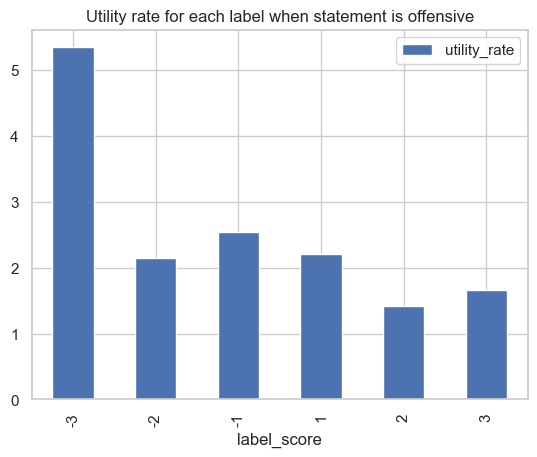

In [31]:
offensive_df = df.groupby(['offensiveness', 'label_score']).size().reset_index(name='count')
offensive_df = offensive_df[offensive_df["offensiveness"] == "offensive"]
offensive_df["num_of_labels"] = df.groupby('label_score').size().values
offensive_df["utility_rate"] = offensive_df["count"] / offensive_df["num_of_labels"] * 100

print(offensive_df)

offensive_df.plot(kind="bar", x='label_score', y='utility_rate', title="Utility rate for each label when statement is offensive")

# From the above data, we can conclude that the column "offensiveness" is useful for predicting the label of the statement. True statements are less offensive. Furthermore, statements that are "pants-fire" are much more offensive that others.

   political_bias  label_score  count  num_of_labels  utility_rate
0          CENTER           -3    189            842     22.446556
1          CENTER           -2    378           1998     18.918919
2          CENTER           -1    351           1657     21.182861
3          CENTER            1    404           2123     19.029675
4          CENTER            2    317           1966     16.124110
5          CENTER            3    286           1683     16.993464
6            LEFT           -3     83            842      9.857482
7            LEFT           -2    276           1998     13.813814
8            LEFT           -1    242           1657     14.604707
9            LEFT            1    349           2123     16.439001
10           LEFT            2    371           1966     18.870804
11           LEFT            3    253           1683     15.032680
12          RIGHT           -3    570            842     67.695962
13          RIGHT           -2   1344           1998     67.26

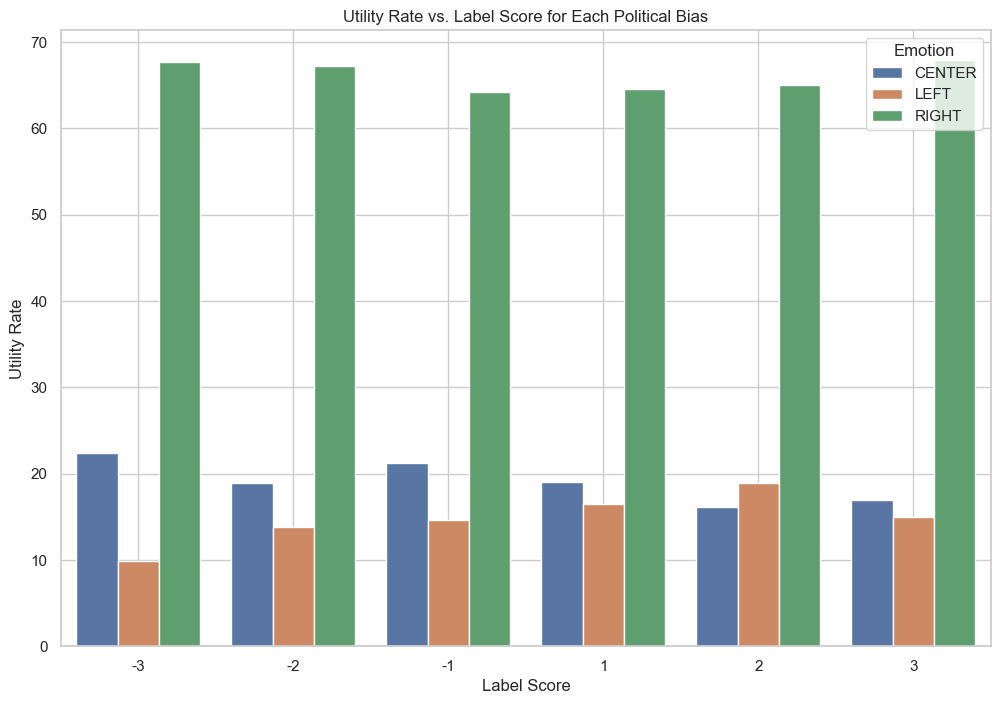

In [32]:
political_bias_df = df.groupby(['political_bias', 'label_score']).size().reset_index(name='count')
num_of_labels = df.groupby('label_score').size()

political_bias_df["num_of_labels"] = political_bias_df["label_score"].map(num_of_labels)
political_bias_df["utility_rate"] = political_bias_df["count"] / political_bias_df["num_of_labels"] * 100
print(political_bias_df)

plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
sns.barplot(x="label_score", y="utility_rate", hue="political_bias", data=political_bias_df)

plt.title('Utility Rate vs. Label Score for Each Political Bias')
plt.xlabel('Label Score')
plt.ylabel('Utility Rate')
plt.grid(True)
plt.legend(title='Emotion')

  political_bias bin_label  count  num_of_labels  utility_rate
0         CENTER     false    918           4497     20.413609
1         CENTER      true   1007           5772     17.446292
2           LEFT     false    601           4497     13.364465
3           LEFT      true    973           5772     16.857242
4          RIGHT     false   2978           4497     66.221926
5          RIGHT      true   3792           5772     65.696466


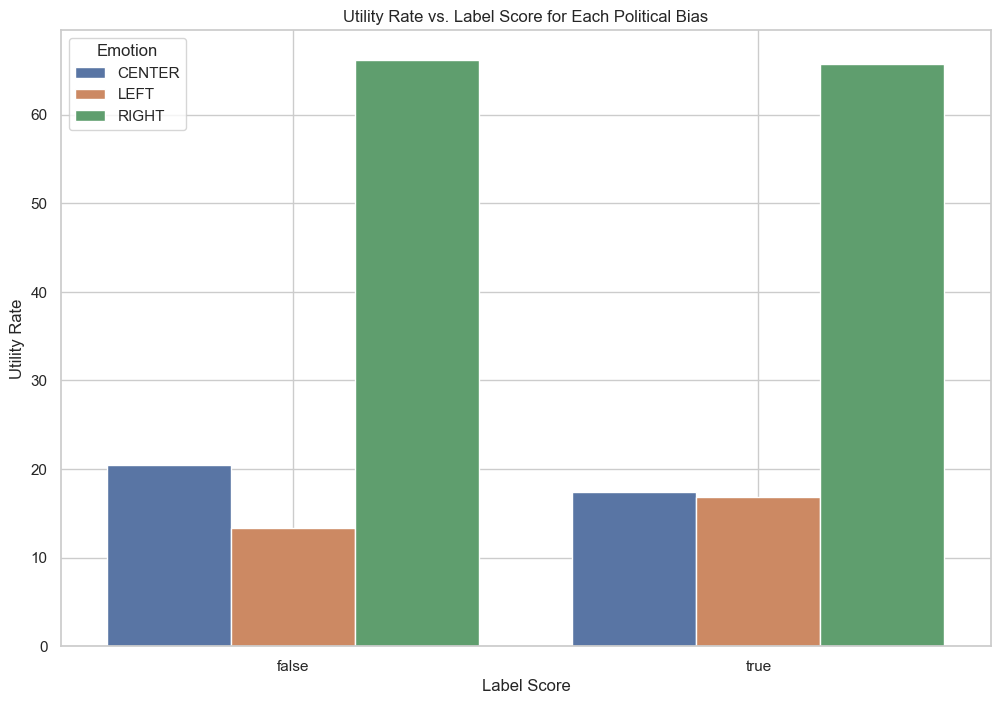

In [33]:
political_bias_df = df.groupby(['political_bias', 'bin_label']).size().reset_index(name='count')
num_of_labels = df.groupby('bin_label').size()

political_bias_df["num_of_labels"] = political_bias_df["bin_label"].map(num_of_labels)
political_bias_df["utility_rate"] = political_bias_df["count"] / political_bias_df["num_of_labels"] * 100
print(political_bias_df)

plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
sns.barplot(x="bin_label", y="utility_rate", hue="political_bias", data=political_bias_df)

plt.title('Utility Rate vs. Label Score for Each Political Bias')
plt.xlabel('Label Score')
plt.ylabel('Utility Rate')
plt.grid(True)
plt.legend(title='Emotion')

# Significance of column "political_bias" for predicting the label of the statement is ambiguous. Statements classified as right wing are majority of statements and the percentage of them don't differ among different labels. Some insight can be gained from sentences classified as centrist or left wing. Generally statements that was classified as centrist are more false, and these classified as left wing are more true. That relationship is more visible in binary classification.